#multiagent using rag and llm in langgraph

In [ ]:
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langgraph.graph import START,StateGraph,END
from typing import Annotated
from typing import TypedDict,Sequence
import operator
from IPython.display import display,Image
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode,tools_condition
from langchain.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage
from pydantic import BaseModel,Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain import PromptTemplate

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

In [4]:
embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\user\OneDrive\Desktop\langgraph\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
llm=ChatGroq(model="gemma2-9b-it")

In [7]:
llm.invoke("what is gen ai")

AIMessage(content="**Gen AI**, short for **Generative Artificial Intelligence**, is a type of artificial intelligence that focuses on creating new content. \n\nThink of it like this:\n\n* **Traditional AI:**  Good at analyzing existing data, recognizing patterns, and making predictions. \n* **Gen AI:** Takes that understanding of patterns and uses it to build something entirely new.\n\n**What can Gen AI create?**\n\n* **Text:**  Stories, poems, articles, code, scripts, emails, letters\n* **Images:** Photos, artwork, illustrations, 3D models\n* **Audio:** Music, sound effects, voiceovers\n* **Video:** Animations, short films\n* **Other:**  Synthetic data, game levels, chemical compounds\n\n**How does it work?**\n\nGen AI models are typically trained on massive datasets of existing content. They learn the underlying rules and structures of that data, then use that knowledge to generate new content that follows similar patterns. \n\n* **Deep Learning:**  A key technique used in Gen AI is 

In [8]:
loader=PyPDFLoader(file_path="C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf")
docs=loader.load()

In [9]:
documents=RecursiveCharacterTextSplitter(chunk_size=400,chunk_overlap=40).split_documents(docs)

In [10]:
documents

[Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='From Wikipedia, the free encyclopedia \nAn illustration of main components of the \ntransformer model from the paper \n"Attention Is All You Need"[1] is a 2017 landmark[2][3] research paper in machine learning authored by \neight scientists working at Google. The paper introduced a new deep learning architecture known as'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al.[4] It is \nconsidered a foundational[5] paper in modern artificial intelligence, as the transformer approach has \nbecome the main architecture of large language models like those based on GPT.[6][7] At the time, the'),
 Document(metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='focus of the research w

In [11]:
db=FAISS.from_documents(documents=documents,embedding=embedding)

In [12]:
vector_db=db.as_retriever()

In [13]:
input="what is transformer"

In [14]:
vector_db.get_relevant_documents(input)

C:\Users\user\AppData\Local\Temp\ipykernel_3648\1757252538.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  vector_db.get_relevant_documents(input)


[Document(id='1e8baac1-525c-4bc1-9703-963142bb31d9', metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='"Transformer" was picked because Uszkoreit liked the sound of that word.[9] \nAn early design document was titled "Transformers: Iterative Self-Attention and Processing for \nVarious Tasks", and included an illustration of six characters from the Transformers animated show. \nThe team was named Team Transformer.[8]'),
 Document(id='18b4fa77-e186-4132-b71b-0d54258f1779', metadata={'source': 'C:\\Users\\user\\OneDrive\\Desktop\\langgraph\\temp.pdf', 'page': 0}, page_content='Some early examples that the team tried their Transformer architecture on included English-to-\nGerman translation, generating Wikipedia articles on "The Transformer", and parsing. These \nconvinced the team that the Transformer is a general purpose language model, and not just good for \ntranslation.[9] \nAs of 2024, the paper has been cited more than 100,000 t

In [15]:
class parser(BaseModel):
    topic:str=Field(description="selected topic")
    reasoning :str=Field(description="reasoning behind the topic")

In [16]:
parser=PydanticOutputParser(pydantic_object=parser)

In [17]:
print(parser.get_format_instructions(),end=" ")

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "reasoning": {"description": "reasoning behind the topic", "title": "Reasoning", "type": "string"}}, "required": ["topic", "reasoning"]}
``` 

In [18]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [19]:
def function_1(state:AgentState):
    print("==> entering into the agent <===")
    messages=state["messages"]
    question=messages[-1]
    print(f" the agent question is {question}")
    template="""
                your task is to classify the following user query  whether the question is [transformer,not related]
                and nothing else you can do
                question:{question}
                {format_instructions}
            """
    
    prompt=PromptTemplate(
        input_variables=[question],
        template=template,
        format_instructions=parser.get_format_instructions()
        )
    
    chain=prompt|llm|StrOutputParser()

    response=chain.invoke({"question":question,"format_instructions":parser.get_format_instructions()})

    return {"messages":[response]}
    

In [20]:
def function_2(state:AgentState):
    print("==> entering into the llm <==")
    messages=state["messages"]
    question=messages[0]
    print(f"the llm question {question}")
    response=llm.invoke(question)
    return {"messages":[response]}

In [21]:
def function_3(state:AgentState):
    print("==> entering into the rag <==")
    messages=state["messages"]
    question=messages[-1]
    print(f"the rag question is {question}")

    template="""
      Answer the following question based on the user query
      {context}
      Question:{question}
    """

    prompt=ChatPromptTemplate.from_template(template)

    chain=prompt|llm|StrOutputParser()

    response=chain.invoke({"context":vector_db,"question":question})
    return {"messages":[response]}

In [22]:
def router(state:AgentState):
    print("->calling route <-")

    messages=state["messages"]
    last_message=messages[-1]
    #the question is entering into router:```json
    #{"topic": "not Related", "reasoning": "The query is about a general AI 
    # concept and not related to Langsmith"}
    print(f"the question is entering into router:{last_message}")
    if "not related" in last_message:
        return "LLM CALL"
    else:
        return "RAG CALL"


In [23]:
#router({"messages":["what is tansformer"]})

In [24]:
graph=StateGraph(AgentState)

In [25]:
graph.add_node("agent",function_1)
graph.add_edge(START,"agent")
graph.add_node("llm",function_2)
graph.add_node("rag",function_3)

graph.add_conditional_edges(
    "agent",
    
    router,
    {
       
        "RAG CALL":"rag",
        "LLM CALL":"llm"
    }
)

graph.add_edge("rag",END)
graph.add_edge("llm",END)

In [26]:
app=graph.compile()

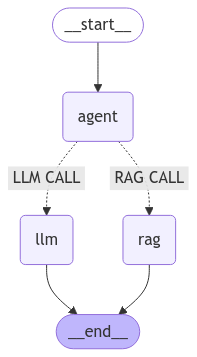

In [27]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [28]:
input="what is education"

In [29]:
app.invoke({"messages":[input]})

==> entering into the agent <===
 the agent question is what is education
->calling route <-
the question is entering into router:```json
{"topic": "not related", "reasoning": "Education is a broad societal concept, not directly related to the capabilities of transformer models."}
``` 

==> entering into the llm <==
the llm question what is education


{'messages': ['what is education',
  '```json\n{"topic": "not related", "reasoning": "Education is a broad societal concept, not directly related to the capabilities of transformer models."}\n``` \n',
  AIMessage(content='Education is a multifaceted and complex concept that encompasses much more than just formal schooling. \n\nHere are some key aspects of education:\n\n**Formal Education:**\n\n* **Structured learning:** This typically involves attending schools or universities, following a curriculum, and receiving instruction from qualified teachers. \n* **Academic subjects:**  Focuses on acquiring knowledge and skills in areas like reading, writing, mathematics, science, history, and the arts.\n* **Qualifications and credentials:**  Leads to diplomas, degrees, and other certifications that can be valuable for employment and further education.\n\n**Informal Education:**\n\n* **Lifelong learning:**  Acquiring knowledge and skills outside of formal institutions through experiences, inte

In [30]:
app.invoke({"messages":["who is president of india"]})

==> entering into the agent <===
 the agent question is who is president of india
->calling route <-
the question is entering into router:```json
{"topic": "not related", "reasoning": "This query is about a factual topic (current president of India) and does not relate to transformer models."}
```
==> entering into the llm <==
the llm question who is president of india


{'messages': ['who is president of india',
  '```json\n{"topic": "not related", "reasoning": "This query is about a factual topic (current president of India) and does not relate to transformer models."}\n```',
  AIMessage(content='The President of India is **Droupadi Murmu**. \n\nShe assumed office on July 25, 2022. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 14, 'total_tokens': 47, 'completion_time': 0.06, 'prompt_time': 7.868e-05, 'queue_time': 0.022038179999999997, 'total_time': 0.06007868}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-08207f09-1d0c-4992-8804-5518cdda55b2-0', usage_metadata={'input_tokens': 14, 'output_tokens': 33, 'total_tokens': 47})]}

In [31]:
app.invoke({"messages":["what is transformer"]})

==> entering into the agent <===
 the agent question is what is transformer
->calling route <-
the question is entering into router:```json
{
  "topic": "transformer",
  "reasoning": "The user is asking for a definition of 'transformer'."
}
``` 

==> entering into the rag <==
the rag question is ```json
{
  "topic": "transformer",
  "reasoning": "The user is asking for a definition of 'transformer'."
}
``` 



{'messages': ['what is transformer',
  '```json\n{\n  "topic": "transformer",\n  "reasoning": "The user is asking for a definition of \'transformer\'."\n}\n``` \n',
  'While I can\'t directly access or process information from external systems or specific objects like the `vectorstore` you\'ve provided, I can certainly give you a definition of "transformer":\n\n**Transformer**\n\nIn the context of artificial intelligence, particularly natural language processing (NLP), a transformer is a type of deep learning model architecture. \n\n**Key Features:**\n\n* **Attention Mechanism:** Transformers rely heavily on an attention mechanism, which allows the model to focus on different parts of an input sequence when processing information. This enables them to capture long-range dependencies and relationships within text.\n* **Encoder-Decoder Structure:**  Most transformers have a structure consisting of an encoder and a decoder. The encoder processes the input sequence, while the decoder gener

In [33]:
state={"messages":["hello how are you",
              "what is your name",
              "what's you're hobby"]}

In [36]:
state["messages"][-1]

"what's you're hobby"